# Maximum Likelihood Estimationとstatsmodels
## Agenda

- binary choice modelをprobit modelで推定する
- Negative binomial model for count dataのパラメーター推定


In [1]:
## create the clean environment
import gc
import matplotlib.pyplot as plt

def clear_all():
    # Clears all the variables from the workspace
    gl = globals().copy()
    for var in gl:
        if var in clean_env_var: 
            continue
        del globals()[var]
    # Garbage collection:
    gc.collect()

def close_plots():
    my_plots = plt.get_fignums()
    for j in my_plots:
        plt.close(plt.figure(j))

clean_env_var = dir()
clean_env_var.append('clean_env_var')

In [2]:
clear_all()

### Hardware

In [4]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


### Python

In [5]:
!python -V

Python 3.7.4


### Install packages

In [6]:
pass

### Import

In [7]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
from scipy.stats import nbinom
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.base.model import GenericLikelihoodModel

## 1. `GenericLikelihoodModel` classとは？

- `scipy` optimization functionのAPIを扱いやすいように提供してくれるstatsmodelsのクラス
- log-likelihood functionにuser-defined MLE modelをplugging-inするだけでパラメータ推定ができる
- automatic differentiationしてくれるのでHessianやその他update functionを設定しなくて良い(defaultで`fit(method='nm')`となっている)




## 2. Probit model

### Data

In [8]:
df = sm.datasets.spector.load_pandas()
print(sm.datasets.spector.NOTE)
df.data.head()

::

    Number of Observations - 32

    Number of Variables - 4

    Variable name definitions::

        Grade - binary variable indicating whether or not a student's grade
                improved.  1 indicates an improvement.
        TUCE  - Test score on economics test
        PSI   - participation in program
        GPA   - Student's grade point average



,GPA,TUCE,PSI,GRADE
0,2.66,20.0,0.0,0.0
1,2.89,22.0,0.0,0.0
2,3.28,24.0,0.0,0.0
3,2.92,12.0,0.0,0.0
4,4.00,21.0,0.0,1.0


### Pre-processing

In [9]:
exog = df.exog
endog = df.endog
exog = sm.add_constant(exog, prepend=True)

### EDA

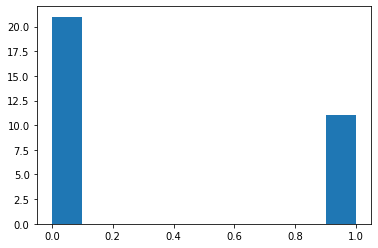

In [10]:
plt.hist(endog);

### Probit 推定モデルの作成

In [11]:
class MyProbit(GenericLikelihoodModel):
    def loglike(self, params):
        exog = self.exog
        endog = self.endog
        q = 2 * endog - 1 ## P(x>c) = 1 - P(x<c)の考え
        return stats.norm.logcdf(q*np.dot(exog, params)).sum() 

### Probit estimation

In [12]:
sm_probit_manual = MyProbit(endog, exog).fit()
print(sm_probit_manual.summary())

Optimization terminated successfully.
         Current function value: 0.400588
         Iterations: 292
         Function evaluations: 494
                               MyProbit Results                               
Dep. Variable:                  GRADE   Log-Likelihood:                -12.819
Model:                       MyProbit   AIC:                             33.64
Method:            Maximum Likelihood   BIC:                             39.50
Date:                Mon, 18 May 2020                                         
Time:                        18:34:45                                         
No. Observations:                  32                                         
Df Residuals:                      28                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

## 3. Negative Binomial Regression for Count Data

type NB-2 functionを考える：

$$
\mathcal{L}(\beta_j; y, \alpha) = \sum_{i=1}^n y_i ln
\left ( \frac{\alpha exp(X_i'\beta)}{1+\alpha exp(X_i'\beta)} \right ) -
\frac{1}{\alpha} ln(1+\alpha exp(X_i'\beta)) + ln \Gamma (y_i + 1/\alpha) - ln \Gamma (y_i+1) - ln \Gamma (1/\alpha)
$$

- $X$: regressors
- $\beta$: params
- $\alpha$: the negative binomial heterogeneity parameter

In [13]:
def _ll_nb2(y, X, beta, alph):
    mu = np.exp(np.dot(X, beta))
    size = 1/alph
    prob = size/(size+mu)
    ll = nbinom.logpmf(y, size, prob)
    return ll

In [14]:
class NBin(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NBin, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self, params):
        alph = params[-1]
        beta = params[:-1]
        ll = _ll_nb2(self.endog, self.exog, beta, alph)
        return -ll

    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        # we have one additional parameter and we need to add it for summary
        self.exog_names.append('alpha')
        if start_params == None:
            # Reasonable starting values
            start_params = np.append(np.zeros(self.exog.shape[1]), .5)
            # intercept
            start_params[-2] = np.log(self.endog.mean())
        return super(NBin, self).fit(start_params=start_params,
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)

### Data

In [15]:
medpar = sm.datasets.get_rdataset("medpar", "COUNT", cache=True).data
medpar.head()

,los,hmo,white,died,age80,type,type1,type2,type3,provnum
0,4,0,1,0,0,1,1,0,0,30001
1,9,1,1,0,0,1,1,0,0,30001
2,3,1,1,1,1,1,1,0,0,30001
3,9,0,1,0,0,1,1,0,0,30001
4,1,0,1,1,1,1,1,0,0,30001


### Pre-processing

In [16]:
y = medpar.los
X = medpar[["type2", "type3", "hmo", "white"]].copy()
X["constant"] = 1

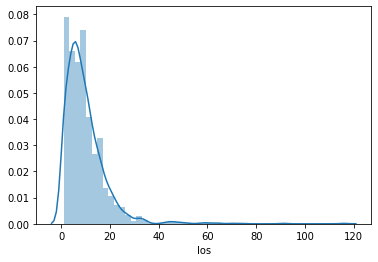

In [17]:
sns.distplot(y);

### Estimation

In [18]:
mod = NBin(y, X)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 3.209014
         Iterations: 805
         Function evaluations: 1238


In [19]:
print('Parameters: ', res.params)
print('Standard errors: ', res.bse)
print('P-values: ', res.pvalues)
print('AIC: ', res.aic)

Parameters:  [ 0.2212642   0.70613942 -0.06798155 -0.12903932  2.31026565  0.44575147]
Standard errors:  [0.05059259 0.07613047 0.05326097 0.06854141 0.06794692 0.01981542]
P-values:  [1.22297920e-005 1.76978024e-020 2.01819161e-001 5.97481600e-002
 2.15079626e-253 4.62688439e-112]
AIC:  9604.95320583016


In [20]:
print(res.summary())

                                 NBin Results                                 
Dep. Variable:                    los   Log-Likelihood:                -4797.5
Model:                           NBin   AIC:                             9605.
Method:            Maximum Likelihood   BIC:                             9632.
Date:                Mon, 18 May 2020                                         
Time:                        18:34:47                                         
No. Observations:                1495                                         
Df Residuals:                    1490                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
type2          0.2213      0.051      4.373      0.000       0.122       0.320
type3          0.7061      0.076      9.275      0.0

### statsmodel implmentationとの比較

In [21]:
res_nbin = sm.NegativeBinomial(y, X).fit(disp=0)
print(res_nbin.summary())

                     NegativeBinomial Regression Results                      
Dep. Variable:                    los   No. Observations:                 1495
Model:               NegativeBinomial   Df Residuals:                     1490
Method:                           MLE   Df Model:                            4
Date:                Mon, 18 May 2020   Pseudo R-squ.:                 0.01215
Time:                        18:34:47   Log-Likelihood:                -4797.5
converged:                       True   LL-Null:                       -4856.5
Covariance Type:            nonrobust   LLR p-value:                 1.404e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
type2          0.2212      0.051      4.373      0.000       0.122       0.320
type3          0.7062      0.076      9.276      0.000       0.557       0.855
hmo           -0.0680      0.053     -1.276      0.2

### REMARKS

- `statsmodels`とR `MASS`パッケージでのimplementationによる推定結果はfourth decimalまで一致する
- standard errorに関してはthe second decimalまで